## --> To load the saved model and run it on the test data, run the cells marked with #+

In [1]:
#+
#ensuring we have latest version of transformers
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-mwz_1km9
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-mwz_1km9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.4.0.dev0-cp37-none-any.whl size=1890659 sha256=3d3123fd443f34a4cbd11bcbccdf4e4871c9ffa11b59c17b72f125556264f0fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-9oejhulg/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers


In [6]:
#+
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from sklearn import metrics
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import gc
import re
import numpy as np
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import setUpFunctions
import evaluation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
#+ unselect wanted language option

# language = 'es'
language = 'en'

cleanTweetsFlag = False #Set to True to use clean tweets and False to use non-cleaned tweets

# Loading in the Data

In [8]:
train_tweets = setUpFunctions.getTrainTweets(language)
trial_tweets = setUpFunctions.getTrialTweets(language)

In [9]:
#+ preparing test data
test_tweets = setUpFunctions.getTestTweets(language)

#converting tweets to lists
if cleanTweetsFlag == True:
    test_texts = test_tweets['tweet_clean'].to_list()
else:
    test_texts = [text.lower() for text in test_tweets['tweet'].to_list()]

#converting emojis from strings to int
test_labels = [int(emoji) for emoji in test_tweets['emoji']]

In [10]:
#preparing train and trial data

#converting tweets to lists
if cleanTweetsFlag == True:
    train_texts = train_tweets['tweet_clean'].to_list()
    trial_texts = trial_tweets['tweet_clean'].to_list()
else:
    train_texts = [text.lower() for text in train_tweets['tweet'].to_list()]
    trial_texts = [text.lower() for text in trial_tweets['tweet'].to_list()]

#converting emojis from strings to int
train_labels = [int(emoji) for emoji in train_tweets['emoji']]
trial_labels = [int(emoji) for emoji in trial_tweets['emoji']]

In [11]:
print(train_texts[20])

#whatremorse #notapologetic #sandiego #view # @ north park, san diego 


# Tokenizing the tweets

In [12]:
#encoding train and trial tweets
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
trial_encodings = tokenizer(trial_texts, truncation=True, padding=True)

# Creating Dataset object for Tensorflow

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
trial_dataset = tf.data.Dataset.from_tensor_slices((dict(trial_encodings), trial_labels))

# Fine-tuning using native Tensorflow

In [14]:
#building the model and compiling it
if language == 'en': 
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=20)   
elif language == 'es':
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=19)   

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [15]:
#training 
#unable to run on GPU for 4 epochs due to google Colab limit and on CPU setting or Jupyter Notebook it was too slow.
model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, validation_data=trial_dataset.shuffle(1000).batch(16))

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

# Saving and Loading the model

In [16]:
#+ 
if language == 'en':
    save_directory = "models/EnglishDistilbertModel" # to load english model
elif language == 'es':
    save_directory = "models/SpanishDistilbertModel" # to load spanish model

In [17]:
#saving the model and the tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/NLP_resources/savedModels/EnglishDistilbertModel/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_resources/savedModels/EnglishDistilbertModel/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_resources/savedModels/EnglishDistilbertModel/vocab.txt',
 '/content/drive/MyDrive/NLP_resources/savedModels/EnglishDistilbertModel/added_tokens.json')

In [18]:
#+
#loading the model and the tokenizer
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/NLP_resources/savedModels/EnglishDistilbertModel were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/NLP_resources/savedModels/EnglishDistilbertModel and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to us

# Making Prediction with unseen tweet

In [19]:
#+
test_text = test_texts[500]
print("Tweet: ", test_text)
print("True label: ", test_labels[500])

Tweet:  before dumping the tank and then after , good times suffering. #lfa27 at firelake arena…
True label:  2


In [20]:
#+
predict_input = loaded_tokenizer.encode(test_text, truncation=True, padding=True, return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
print("Predicted label: ", prediction_value)

Predicted label:  6


# Making Predictions of all test tweets

In [21]:
#+
prediction_values = []

for text in test_texts:
    predict_input = loaded_tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    prediction_values.append(prediction_value)

In [22]:
#+
def confusion_matrix(gold_labels, predicted):
    classes = np.unique(gold_labels)

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(gold_labels, predicted)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

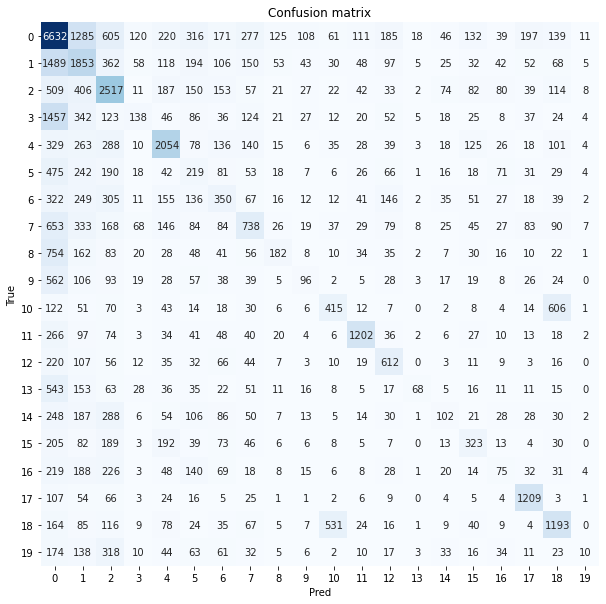

In [23]:
#+
confusion_matrix(test_labels, prediction_values)

In [24]:
#+ applying official evaluation script
evaluation.main(test_labels, prediction_values)

Macro F-Score (official): 30.391
-----
Micro F-Score: 39.976
Precision: 39.976
Recall: 39.976
